In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
class Lipschitz_Linear(nn.Module):
    def __init__(self, h, activation = None):
        super(Lipschitz_Linear, self).__init__()
        self.B = 2 ## Upper bound on product of weights norms
        self.lip_reg = 0.0005 ## learning rate on Lip regularisation !
        self.order = float('inf') ### order of L_j norm
        h = h
        self.activation = activation
        layers = []
        self.linear_layers = []
        self.Norm_constraints = torch.rand(len(h) - 1) * self.B
        for layer in range(1,len(h)):
            linear = nn.Linear(h[layer -1], h[layer])
            layers.append(linear)
            layers.append(nn.BatchNorm1d(h[layer], affine=True))
            self.linear_layers.append(linear)
            if activation is not None:
                layers.append(self.activation())
        self.univariate_nn = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.univariate_nn(x)
    
    def compute_constraint_gradient(self):
        self.grads_norm_constraints = []
        prod = torch.prod(self.Norm_constraints)
        for i in range(len(self.Norm_constraints)):
            grad = torch.sum(self.linear_layers[i].weight.grad * (self.linear_layers[i].weight.data / (torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)))) + self.lip_reg * (prod / self.Norm_constraints[i])  * torch.exp(7 * ((prod) - self.B))
            self.grads_norm_constraints.append(grad)

    def upper_lipschitz_bound(self):
        return torch.prod(self.Norm_constraints)

    def update_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.Norm_constraints[i] -= 0.001 * self.grads_norm_constraints[i]
    
    def project_on_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.linear_layers[i].weight.data *= self.Norm_constraints[i] / torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)
    
    def train_enforce_constraints(self):
        self.compute_constraint_gradient()
        self.update_norm_constraints()
        self.project_on_norm_constraints()





In [15]:
class Lipschitz_GRU(nn.Module):
    def __init__(self, in_dim ,hidden, depth = 2, activation = nn.ReLU):
        super(Lipschitz_GRU, self).__init__()
        self.hidden = hidden
        self.depth = depth

        self.B = 2 ## Upper bound on product of weights norms
        self.lip_reg = 0.0005 ## learning rate on Lip regularisation !
        self.order = float('inf') ### order of L_j norm
        self.activation = activation
        self.Norm_constraints = torch.rand(self.depth) * self.B
        self.gru = nn.GRU(in_dim, self.hidden, num_layers = self.depth, batch_first=True)
        
    def forward(self, x):
        out, self.hidden_state = self.gru(x, self.hidden_state)
        return out
    
    def init_hidden(self, batch_size):
        self.hidden_state = torch.zeros(self.depth, batch_size, self.hidden)
    
    def compute_constraint_gradient(self):
        self.grads_norm_constraints = []
        prod = torch.prod(self.Norm_constraints)
        for i in range(len(self.Norm_constraints)):
            grad = torch.sum(self.linear_layers[i].weight.grad * (self.linear_layers[i].weight.data / (torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)))) + self.lip_reg * (prod / self.Norm_constraints[i])  * torch.exp(7 * ((prod) - self.B))
            self.grads_norm_constraints.append(grad)

    def upper_lipschitz_bound(self):
        return torch.prod(self.Norm_constraints)

    def update_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.Norm_constraints[i] -= 0.001 * self.grads_norm_constraints[i]
    
    def project_on_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.linear_layers[i].weight.data *= self.Norm_constraints[i] / torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)
    
    def train_enforce_constraints(self):
        self.compute_constraint_gradient()
        self.update_norm_constraints()
        self.project_on_norm_constraints()





In [73]:
test = Lipschitz_GRU(in_dim = 1, hidden = 3)
test.init_hidden(32)
output = test(torch.randn(32,1,1))
target = torch.randn(32,1,3)
criterion = nn.MSELoss()
loss = criterion(output, target)
loss.backward()
test.gru.weight_ih_l0.grad

tensor([[-5.0901e-04],
        [-6.0729e-04],
        [ 1.5966e-05],
        [ 4.4473e-03],
        [ 2.8996e-03],
        [ 1.6401e-04],
        [-7.9518e-04],
        [ 1.1130e-02],
        [-1.6209e-03]])

In [246]:
#steps = 10
class KAN_RNN_Layer(nn.Module):
    def __init__(self, N_Agents, in_dim, hidden, depth, n_timesteps, sys_param_lam = 0.1):
        """ 
        in_dim:Dimension of Agent information, i.e cartesian coordinates R^2
        """
        super(KAN_RNN_Layer, self).__init__()
        self.N_Agents = N_Agents
        self.in_dim = in_dim
        self.hidden = hidden
        self.sys_param_lam = sys_param_lam
        #TODO
        self.L = [1. for _ in range(in_dim)] ## for projecting into bounds if Agent tries to leave rect
        self.Network_stack = nn.ModuleList()
        self.linear_Network_stack = nn.ModuleList()
        self.activation = nn.ReLU()
        self.num_forward_steps = n_timesteps
        for _ in range(self.N_Agents):
            Networks = nn.ModuleList()
            for _ in range(self.N_Agents):
                Networks.append(Lipschitz_GRU(in_dim = self.in_dim ,hidden = self.hidden, depth = depth)) ## Dimension of input x -> indim, depth number of stacked Gru Layers, hidden Numer of Neurons in the GRu Layers
            self.Network_stack.append(Networks)
            self.linear_Network_stack.append(Lipschitz_Linear([N_Agents * hidden, self.in_dim]))

    def time_step(self, x):
        outs = torch.zeros_like(x)
        for i in range(self.N_Agents): ## out
            output_list = []
            for j in range(self.N_Agents): ### in
                output_list.append(self.Network_stack[i][j](x[:,j,:].unsqueeze(1)))
            out = self.linear_Network_stack[i](self.activation(torch.cat(output_list, dim=1).reshape(-1, self.N_Agents * self.hidden)))
            outs[:,i,:] = out
        return outs

    def system_dynamics(self,u, x_prev, train = False):
        """
            x_prev = [Batch_size, N_Agents, in_dim]
        """
        x_new = torch.zeros_like(x_prev)
        
        for i in range(self.in_dim):
            x_state = (x_prev + self.sys_param_lam * u)[:,:,i]
            x_new[:,:,i] = torch.clamp(x_state, min = 0, max = self.L[i])
            if train == True:
                self.penalty += torch.sum(torch.clamp(x_state - self.L[i], min=0)) + torch.sum(torch.clamp(-x_state, min=0)) #### Do not leave the rect!!!
        return x_new
    
    def forward(self, x, train = False):
        """
        x: Inital States [Batch_size, N_Agents, in_dim] 

        return 
        control_trajectory: controller output [Num_timesteps ,Batch_size, N_Agents, in_dim]
        outs: State of Agents [Num_timesteps ,Batch_size, N_Agents, in_dim]  

        """ 
        self.penalty = 0
        outs = torch.zeros(self.num_forward_steps, *x.shape)
        control_trajectory = torch.zeros(self.num_forward_steps, *x.shape) ## Assume u of same shape as x!
        for i in range(self.num_forward_steps):
            outs[i] = x
            u = self.time_step(x)
            x = self.system_dynamics(u, x, train)
            control_trajectory[i] = u
        return outs, control_trajectory


    def init_hidden(self, batch_size):
        for lists in self.Network_stack:
            for gru in lists:
                gru.init_hidden(batch_size)

    def train_enforce_constraints(self):
        Lip_lin.train_enforce_constraints()
        self.fc2.train_enforce_constraints()

         


In [299]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i], max=L[i])
    return x


In [300]:
N_Agents = 2
in_dim = 1
batch_size = 8
n_samples = 128
timesteps = 100
lam = 0.1
control_energy_reg = 1e-5  ### regularization on maximum control energy
k_max = 128

In [249]:
import Ergodic_Loss
import sys
sys.path.append(r'C:\Users\prass\Documents\Code\KAN\KAN_Test\Ergodic_Loss.py') 
import importlib
importlib.reload(Ergodic_Loss)

criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = 1, k_max = k_max,control_energy_reg = control_energy_reg)
model = KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 16, depth = 2, n_timesteps = timesteps,sys_param_lam= lam)
model.init_hidden(batch_size = batch_size)

In [301]:
print(criterion.k_max)

256


In [212]:
#### Problem heavily influenced by system dynamic -> i.e control max energy
#### Getting stuck in local optima escapes after a lot of steps


In [324]:
epochs = 100  # Number of epochs to train
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_loss = []
test_loss = []
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim), train = True)
        loss = criterion(x = outputs, u = control) + model.penalty * 1e-5 ## punishment on leaving the rect
        loss.backward()
        optimizer.step()
        #print("did one step")
        #model.train_enforce_constraints()
        running_loss += loss.item()
    avg_loss = running_loss / n_samples
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
#plt.plot(test_loss)
#plt.title('test_loss')
#plt.legend()
#plt.show()
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

Epoch [1/100], Loss: 0.001403
Epoch [2/100], Loss: 0.001409
Epoch [3/100], Loss: 0.001427
Epoch [4/100], Loss: 0.001440
Epoch [5/100], Loss: 0.001448
Epoch [6/100], Loss: 0.001458
Epoch [7/100], Loss: 0.001461
Epoch [8/100], Loss: 0.001463
Epoch [9/100], Loss: 0.001430
Epoch [10/100], Loss: 0.001438
Epoch [11/100], Loss: 0.001426
Epoch [12/100], Loss: 0.001427
Epoch [13/100], Loss: 0.001480
Epoch [14/100], Loss: 0.001418
Epoch [15/100], Loss: 0.001441
Epoch [16/100], Loss: 0.001472
Epoch [17/100], Loss: 0.001426
Epoch [18/100], Loss: 0.001465
Epoch [19/100], Loss: 0.001399
Epoch [20/100], Loss: 0.001413
Epoch [21/100], Loss: 0.001400
Epoch [22/100], Loss: 0.001444
Epoch [23/100], Loss: 0.001380
Epoch [24/100], Loss: 0.001433
Epoch [25/100], Loss: 0.001426
Epoch [26/100], Loss: 0.001430
Epoch [27/100], Loss: 0.001420
Epoch [28/100], Loss: 0.001450
Epoch [29/100], Loss: 0.001386
Epoch [30/100], Loss: 0.001411
Epoch [31/100], Loss: 0.001375
Epoch [32/100], Loss: 0.001383
Epoch [33/100], L

In [322]:
#plot trajectory
model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
print(inital_state)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
print(outs.shape)
print(outs)



tensor([[[0.5565]]])
torch.Size([100, 1, 1, 1])
tensor([[[[0.5565]]],


        [[[0.6443]]],


        [[[0.7611]]],


        [[[0.8739]]],


        [[[0.9583]]],


        [[[1.0000]]],


        [[[0.9973]]],


        [[[0.9475]]],


        [[[0.8516]]],


        [[[0.7120]]],


        [[[0.5349]]],


        [[[0.3465]]],


        [[[0.1602]]],


        [[[0.0000]]],


        [[[0.0000]]],


        [[[0.0000]]],


        [[[0.0000]]],


        [[[0.0051]]],


        [[[0.0509]]],


        [[[0.1296]]],


        [[[0.2325]]],


        [[[0.3499]]],


        [[[0.4720]]],


        [[[0.5886]]],


        [[[0.6891]]],


        [[[0.7651]]],


        [[[0.8105]]],


        [[[0.8218]]],


        [[[0.7980]]],


        [[[0.7410]]],


        [[[0.6551]]],


        [[[0.5470]]],


        [[[0.4250]]],


        [[[0.2988]]],


        [[[0.1787]]],


        [[[0.0747]]],


        [[[0.0000]]],


        [[[0.0000]]],


        [[[0.0000]]],


        [[[0.027

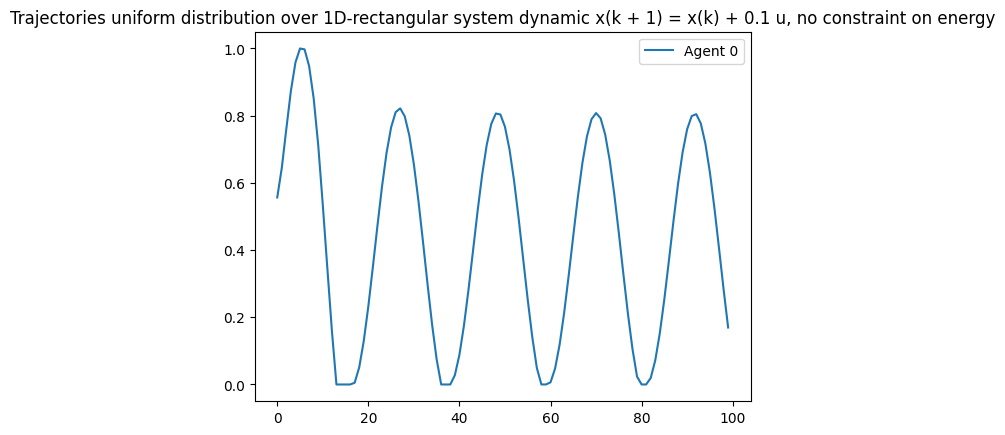

In [323]:
for i in range(N_Agents):
    plt.plot(outs[:,:,i,:].squeeze().detach(), label = f'Agent {i}')
plt.title(f'Trajectories uniform distribution over 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, no constraint on energy')
plt.legend()
plt.show()

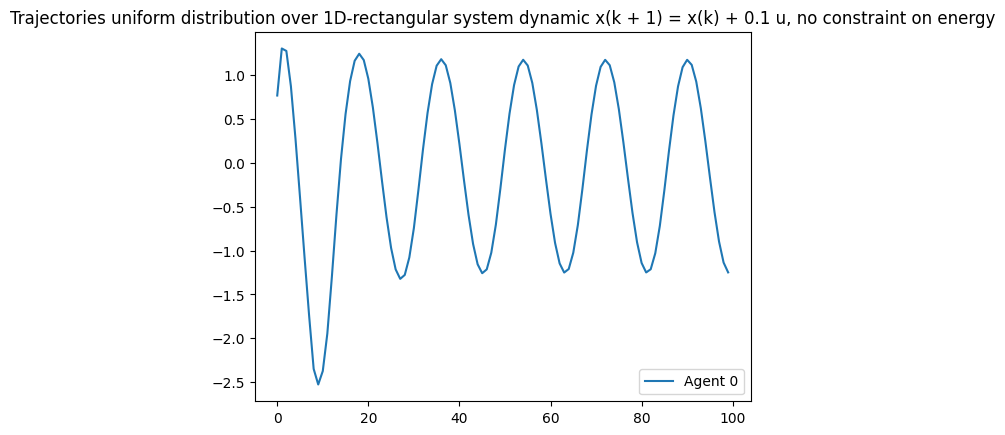

In [290]:
for i in range(N_Agents):
    plt.plot(control[:,:,i,:].squeeze().detach(), label = f'Agent {i}')
plt.title(f'Trajectories uniform distribution over 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, no constraint on energy')
plt.legend()
plt.show()


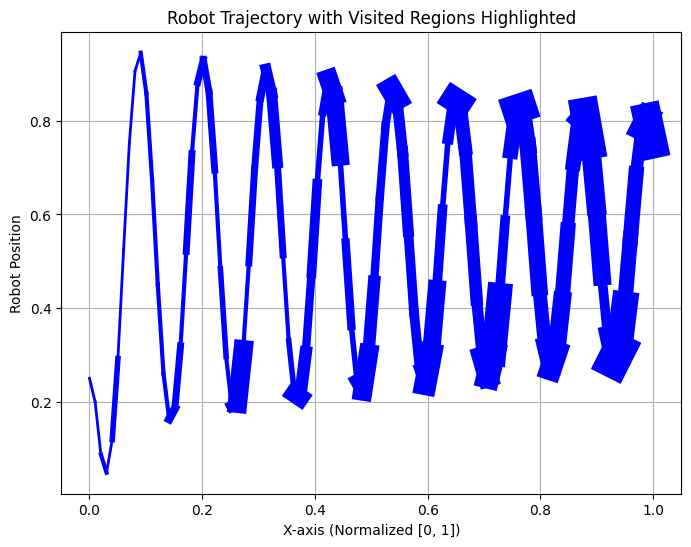

In [102]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create a tensor of shape [n, 1, 1, 1]
n = 100  # Number of time steps (positions)
x_tensor = torch.randn(n, 1, 1, 1)  # Random tensor for example
x_vals = outs.squeeze()  # Shape: [n]

# Normalize the x-axis values to lie between [0, 1]
x_axis = np.linspace(0, 1, n)

# Create a plot to visualize the trajectory
plt.figure(figsize=(8, 6))

# Track the number of visits to each region
visited_counts = np.zeros_like(x_axis)  # Initialize a counter array

# Plot the trajectory by connecting the points
for i in range(1, n):
    # Find the range of positions between x_vals[i-1] and x_vals[i]
    line_start = x_vals[i - 1].item()
    line_end = x_vals[i].item()

    # Increase the visit count for the visited range
    step_size = np.abs(line_end - line_start)  # step size (difference between positions)
    
    # For simplicity, we consider the "visit" of the robot as the range it passed through
    visit_indices = np.linspace(min(line_start, line_end), max(line_start, line_end), 10)  # Divide into 10 steps
    for visit in visit_indices:
        # Increase visit count for each step in the range
        idx = np.digitize(visit, x_axis) - 1  # Find the closest x_axis index
        if 0 <= idx < len(visited_counts):
            visited_counts[idx] += 1

    # Determine line thickness based on the number of visits to the region
    thickness = visited_counts[np.digitize(line_start, x_axis) - 1]  # Use the first point to determine thickness
    plt.plot([x_axis[i - 1], x_axis[i]], [line_start, line_end], color='blue', linewidth=thickness)

# Add labels and title
plt.title('Robot Trajectory with Visited Regions Highlighted')
plt.xlabel('X-axis (Normalized [0, 1])')
plt.ylabel('Robot Position')
plt.grid(True)

# Show the plot
plt.show()


tensor([[[-0.5733, -1.1735],
         [-0.2110,  1.3537],
         [-0.8912,  0.4967],
         [ 1.6755, -0.6769]],

        [[-1.0037, -0.9008],
         [ 1.1723,  1.1508],
         [ 0.8098,  0.8319],
         [-0.9783, -1.0819]],

        [[-0.7334, -0.4555],
         [ 1.3093, -0.9915],
         [ 0.6001,  1.6201],
         [-1.1761, -0.1730]],

        [[-0.2924,  0.0295],
         [-1.2782,  0.0803],
         [ 0.0702, -1.4653],
         [ 1.5005,  1.3555]]], grad_fn=<CopySlices>)
tensor([[[ 0.0798, -0.9756],
         [-0.8564,  1.3121],
         [-0.8203,  0.6041],
         [ 1.5969, -0.9406]],

        [[-0.9404, -0.9134],
         [ 1.1987,  1.1471],
         [ 0.7762,  0.8373],
         [-1.0345, -1.0710]],

        [[-0.5329,  1.6368],
         [ 1.3360, -0.9537],
         [ 0.4941, -0.0795],
         [-1.2972, -0.6036]],

        [[ 0.2098, -0.1779],
         [-1.4176, -0.1371],
         [-0.1664, -1.2360],
         [ 1.3742,  1.5510]]], grad_fn=<CopySlices>)
tensor([[[ 0